In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


random forest models modified. changed criterion to absolute error

In [2]:
def add_t_minus(df, n):
    if n == 0:
        return df
    df_res = df.copy()
    for i in range(1,n+1):
        df_shifted = df.shift(i)
        for cname in df_shifted.columns:
            df_shifted.rename(columns = {cname:cname+'_'+str(i)}, inplace = True)
        df_res = df_res.join(df_shifted)
    df_res = df_res.interpolate(method='spline', limit_direction='backward', order=1)
    return df_res

def sj_preprocess_data(features, labels=None, tminus=0):

    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="spline", order=1)
    
    if labels is not None:
        nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features, tminus)


def iq_preprocess_data(features, labels=None, tminus=0):

    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="quadratic", order=1)
    
    if labels is not None:
        nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features, tminus)



def get_data(features_path, labels_path=None, sj_tminus=0, iq_tminus=0):
    if labels_path is not None:
        labels = pd.read_csv(labels_path,
                           index_col=[0,1,2])

    features = pd.read_csv(features_path,
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

    # Separate data for San Juan
    sj_features = features.loc['sj']
    if labels_path is not None:
        sj_labels = labels.loc['sj']

    # Separate data for Iquitos
    iq_features = features.loc['iq']
    if labels_path is not None:
        iq_labels = labels.loc['iq']

    if labels_path is not None:
        sj_f, sj_l = sj_preprocess_data(sj_features, sj_labels, sj_tminus)
        iq_f, iq_l = iq_preprocess_data(iq_features, iq_labels, iq_tminus)
        return sj_f, sj_l, iq_f, iq_l

    return sj_preprocess_data(sj_features, None, sj_tminus), iq_preprocess_data(iq_features, None, iq_tminus)


In [3]:
sj_tminus = 8
iq_tminus = 8
sj_X_train, sj_y_train, iq_X_train, iq_y_train = get_data('dengue_features_train.csv',
                                                        'dengue_labels_train.csv',
                                                        sj_tminus=sj_tminus,
                                                        iq_tminus=iq_tminus,
                                                        )

# load the provided data
train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

# Separate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

sj_X_train, sj_y_train = preprocess_data(sj_train_features,sj_train_labels)

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

iq_X_train, iq_y_train = preprocess_data(iq_train_features,iq_train_labels)

In [4]:
#split data in train and test
sj_X_train, sj_X_test, sj_y_train, sj_y_test = train_test_split(
    sj_X_train, sj_y_train, test_size=0.3, shuffle=False)


iq_X_train, iq_X_test, iq_y_train, iq_y_test = train_test_split(
iq_X_train, iq_y_train, test_size=0.3, shuffle=False)

#remove everythin before 2002, it doesnt seem to have any value
iq_X_train = iq_X_train.loc['2002-01-01':]
iq_y_train = iq_y_train.loc['2002-01-01':]


In [5]:
sj_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ndvi_ne,655.0,0.085308,0.085051,-0.290200,0.042304,0.082313,0.120275,0.446267
ndvi_nw,655.0,0.096682,0.078717,-0.130950,0.050250,0.090200,0.134000,0.437100
ndvi_se,655.0,0.181044,0.054837,0.036000,0.146207,0.178579,0.212529,0.393129
ndvi_sw,655.0,0.168472,0.055406,-0.063457,0.134221,0.169529,0.203043,0.381420
precipitation_amt_mm,655.0,34.314218,41.118100,0.000000,0.925000,21.530000,50.610000,287.550000
...,...,...,...,...,...,...,...,...
station_avg_temp_c_8,655.0,27.055881,1.361137,22.842857,25.928571,27.300000,28.192857,30.071429
station_diur_temp_rng_c_8,655.0,6.870693,0.820428,4.528571,6.371429,6.871429,7.385714,9.914286
station_max_temp_c_8,655.0,31.697876,1.634533,27.200000,30.600000,31.700000,32.800000,35.600000
station_min_temp_c_8,655.0,22.577539,1.483195,17.800000,21.700000,22.800000,23.900000,25.600000


In [6]:
iq_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ndvi_ne,286.0,0.266523,0.083806,0.088616,0.201246,0.262879,0.323439,0.488400
ndvi_nw,286.0,0.231772,0.075290,0.072986,0.174504,0.223244,0.284818,0.428771
ndvi_se,286.0,0.246770,0.076435,0.029880,0.192014,0.243700,0.300018,0.473400
ndvi_sw,286.0,0.259817,0.081547,0.064743,0.202714,0.258489,0.315911,0.493443
precipitation_amt_mm,286.0,66.309045,35.701824,0.000000,40.715000,63.235000,88.940000,173.450000
...,...,...,...,...,...,...,...,...
station_avg_temp_c_8,286.0,27.589651,0.945623,21.400000,27.169036,27.710000,28.250000,30.800000
station_diur_temp_rng_c_8,286.0,10.268360,1.554859,5.200000,9.225000,10.241667,11.162500,15.800000
station_max_temp_c_8,286.0,33.932502,1.259300,30.100000,33.200000,33.850000,34.500000,42.200000
station_min_temp_c_8,286.0,21.462733,1.291541,16.800000,20.800000,21.700000,22.400000,24.200000


In [7]:
# compute the correlations
sj_correlations = sj_X_train.corr()
iq_correlations = iq_X_train.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

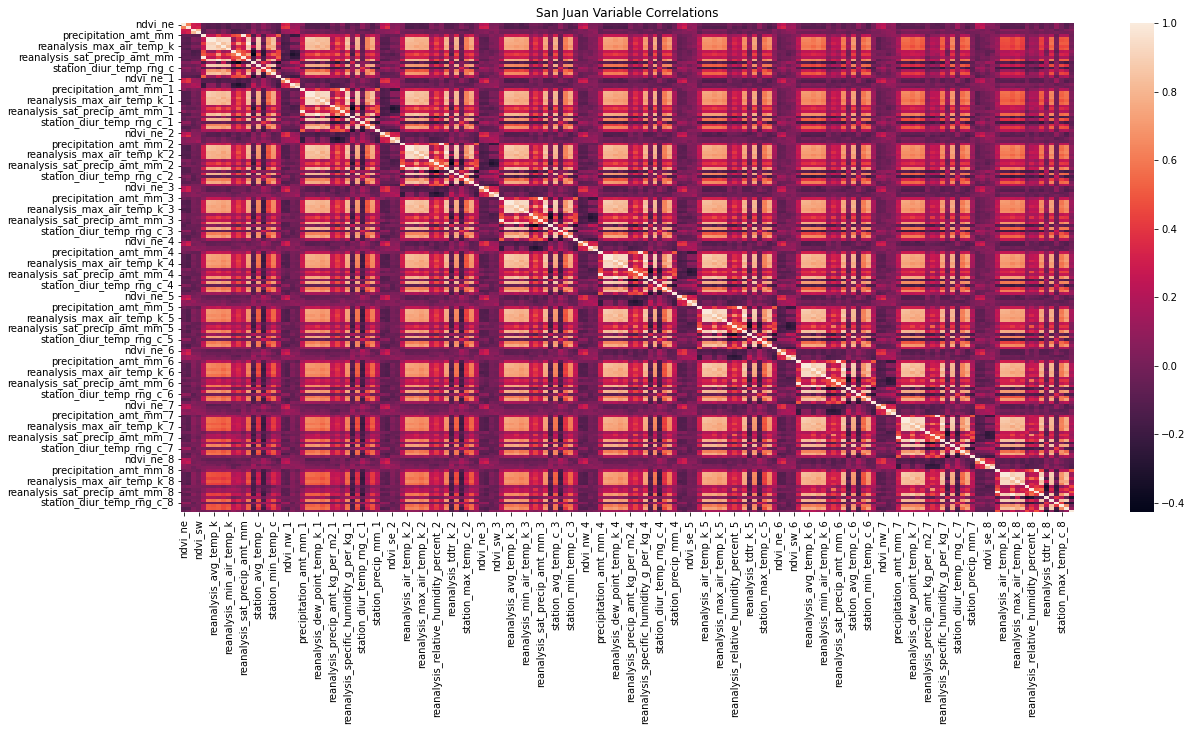

In [8]:
plt.rcParams["figure.figsize"] = (20,9)

# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

In [9]:
sj_rf = XGBRegressor(max_depth=5,learning_rate=0.7,n_estimators=100,n_jobs=-1)                        
sj_rf.fit(sj_X_train, sj_y_train)
print(mean_absolute_error(sj_y_train, sj_rf.predict(sj_X_train)))
print(mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.00029804342109661104
25.861122339221506


/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [10]:
sj_rf.feature_importances_

array([2.11927632e-04, 6.14462886e-04, 2.20811518e-04, 2.30653249e-02,
       9.59652942e-04, 9.71149129e-05, 4.07351268e-04, 5.94561268e-03,
       3.80840944e-03, 7.07242347e-04, 2.84475449e-04, 3.87440174e-04,
       0.00000000e+00, 6.97504802e-05, 6.90865199e-05, 2.60059396e-03,
       1.13823940e-03, 2.18200398e-06, 1.92313490e-03, 1.27575803e-03,
       1.36902745e-04, 9.92728746e-05, 3.60155366e-02, 3.19399461e-02,
       9.52823961e-04, 1.50546175e-03, 7.97807123e-04, 1.38417855e-02,
       3.59701575e-04, 2.99920002e-03, 1.61869946e-04, 1.06783891e-05,
       0.00000000e+00, 8.49400298e-04, 1.50271386e-04, 7.31639830e-06,
       4.28109925e-05, 1.07258558e-04, 1.00265734e-05, 4.33199712e-05,
       3.01888576e-05, 5.96882775e-04, 1.15668111e-01, 5.94739640e-06,
       4.83822714e-06, 2.08594324e-03, 1.61317494e-02, 6.28280407e-03,
       5.04959957e-04, 9.02415013e-06, 5.97088423e-04, 1.23108702e-03,
       0.00000000e+00, 8.11479140e-07, 2.00823386e-04, 4.09286842e-03,
      

<AxesSubplot:ylabel='cols'>

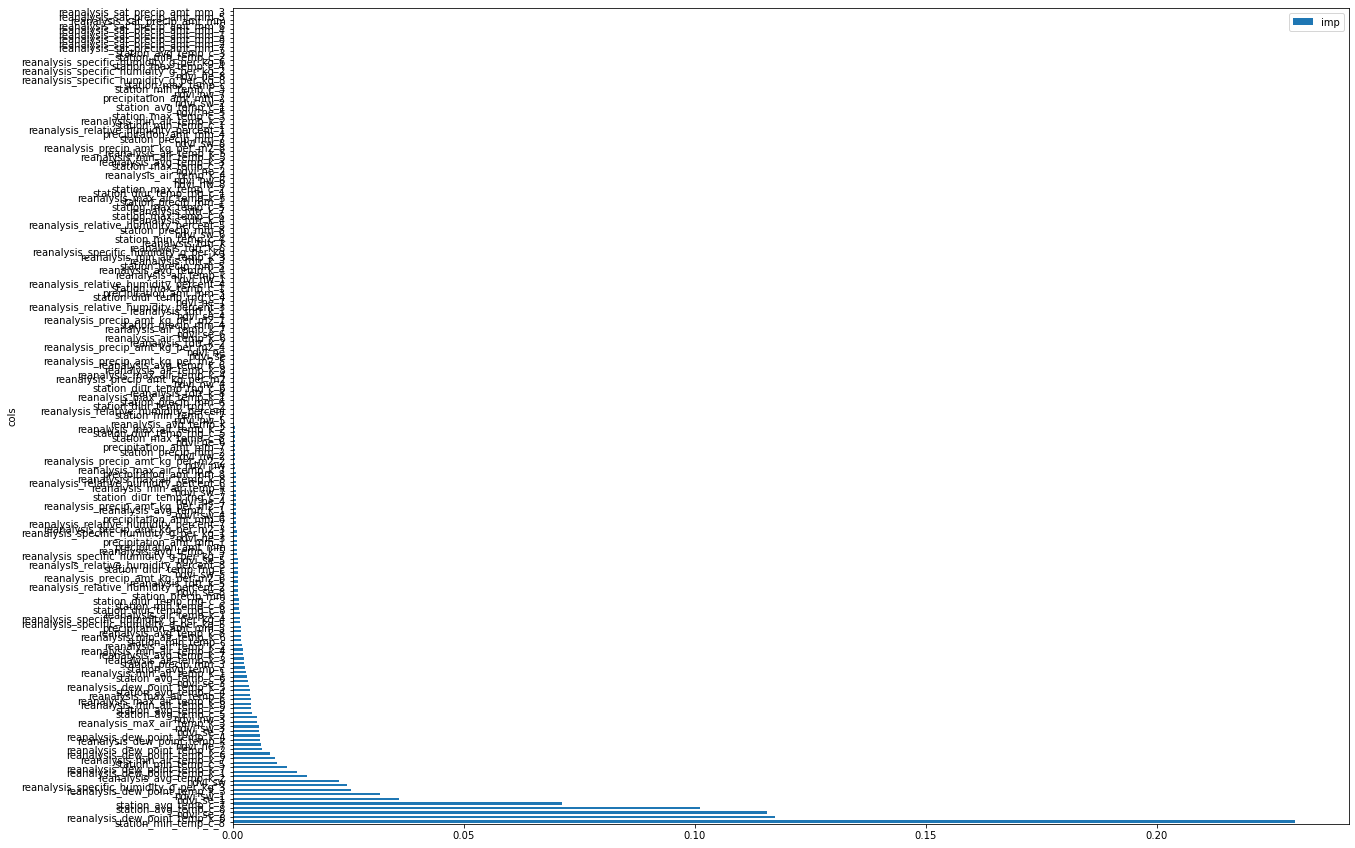

In [11]:
plt.rcParams["figure.figsize"] = (20,15)
(pd.DataFrame(dict(cols=sj_X_train.columns, imp=sj_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

In [12]:
iq_rf = XGBRegressor(max_depth=5,learning_rate=0.7,n_estimators=100,n_jobs=-1) 
iq_rf.fit(iq_X_train, iq_y_train)
print(mean_absolute_error(iq_y_train, iq_rf.predict(iq_X_train)))
print(mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.00026156572778370364
9.219897140677158


/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [13]:
iq_rf.feature_importances_

array([8.1747631e-04, 3.2109052e-03, 6.5218494e-03, 9.3108712e-05,
       1.8016628e-03, 5.5437593e-04, 1.7302349e-02, 5.8431632e-04,
       1.7830232e-02, 1.8998455e-04, 3.0584700e-04, 1.7275692e-04,
       0.0000000e+00, 6.8232726e-04, 7.2415628e-06, 4.1435669e-06,
       3.4952771e-03, 4.6613414e-04, 6.4523099e-04, 9.5446216e-04,
       1.3637041e-03, 3.9512932e-04, 8.9009795e-03, 3.9950060e-03,
       9.1407466e-04, 1.7259174e-04, 4.5511854e-07, 2.4413055e-06,
       2.9240758e-03, 3.4050643e-02, 1.4463793e-04, 1.9758004e-03,
       0.0000000e+00, 1.4020751e-03, 3.2209782e-03, 6.6292975e-03,
       1.1142916e-07, 1.5270560e-05, 1.6545292e-04, 5.3728046e-04,
       1.5027352e-05, 1.9507782e-07, 4.2139558e-04, 8.2962948e-04,
       4.2808239e-04, 7.2075555e-04, 1.8127477e-07, 4.1004467e-05,
       1.4743821e-02, 1.2922488e-03, 2.7556391e-07, 2.6469220e-09,
       0.0000000e+00, 2.5039066e-02, 7.7945242e-06, 3.4553256e-08,
       1.7260120e-03, 8.0302246e-03, 4.6743098e-06, 5.0782104e

<AxesSubplot:ylabel='cols'>

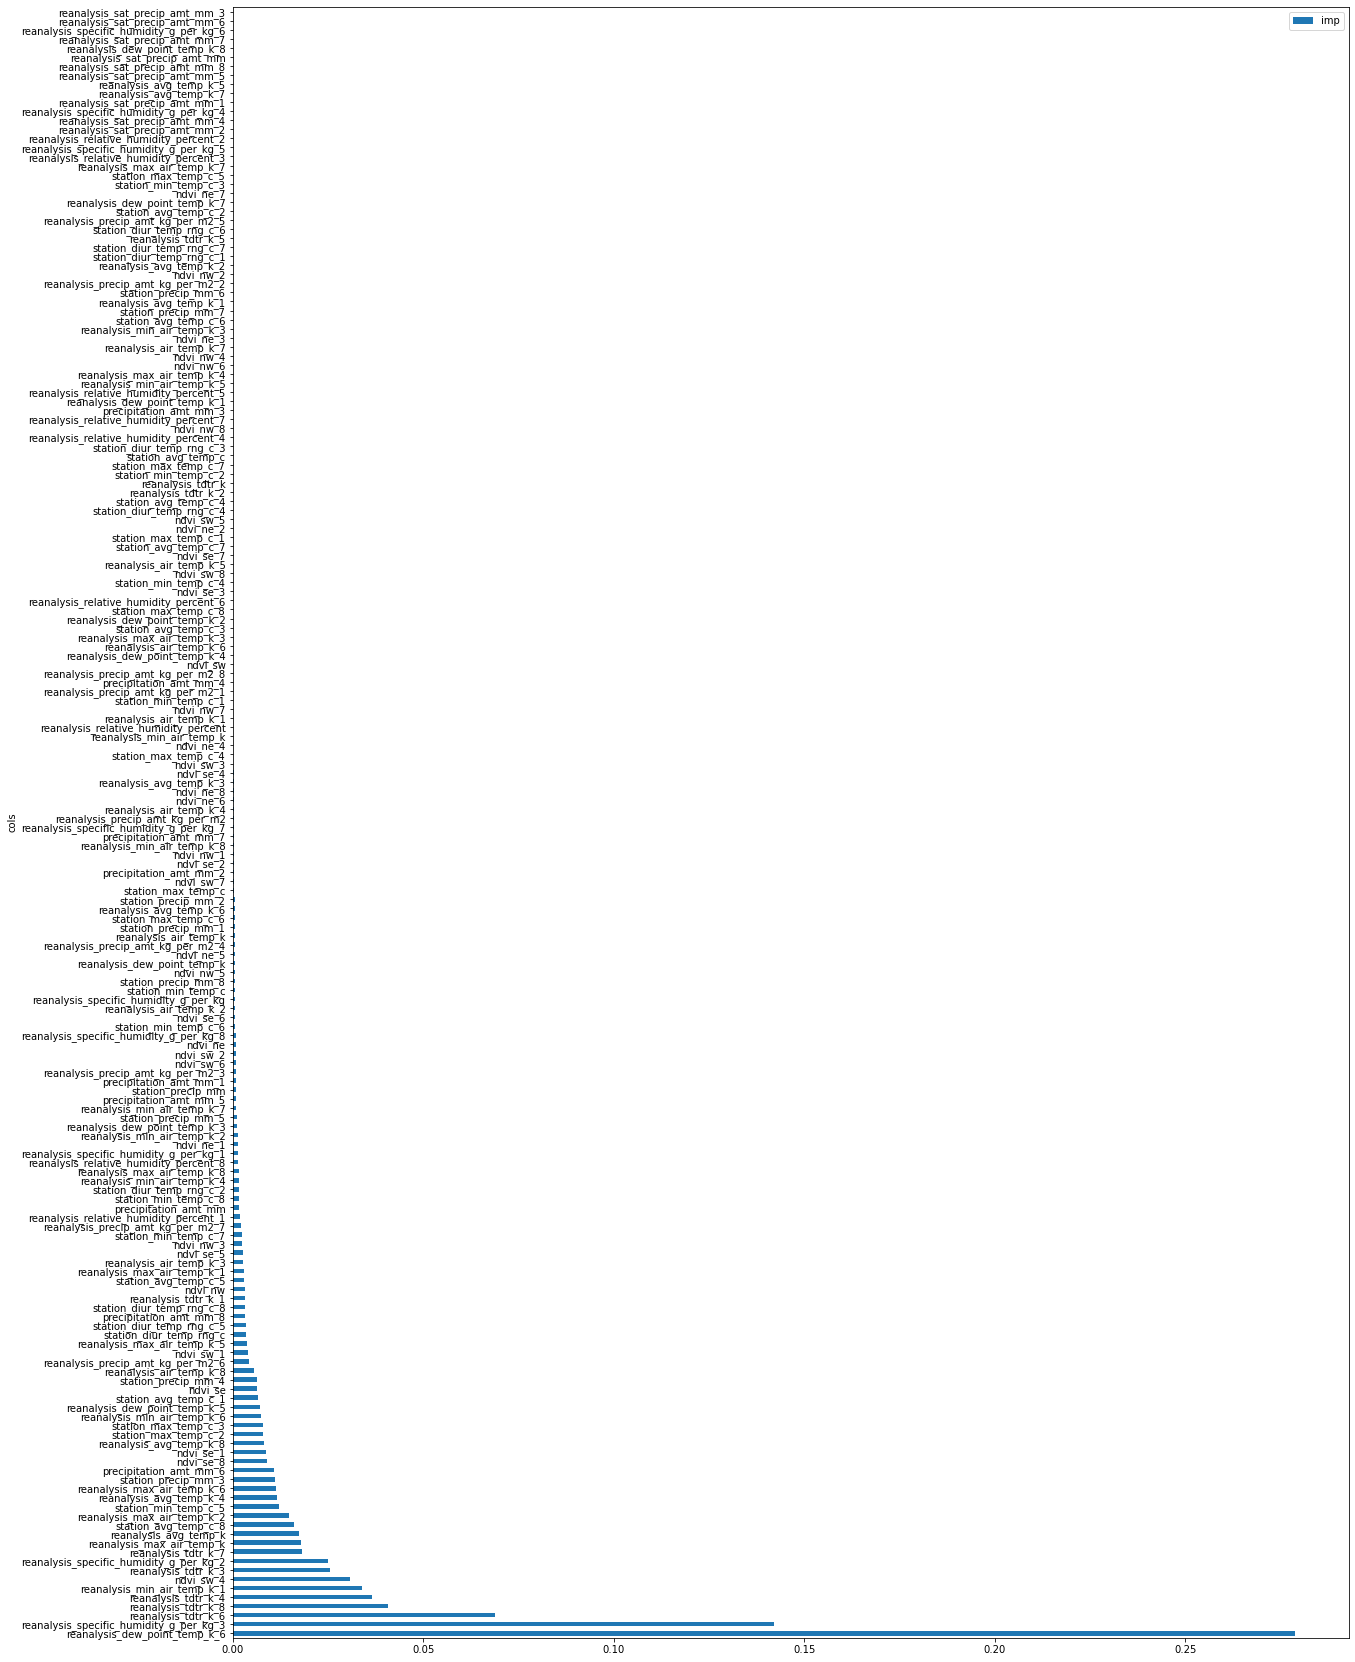

In [14]:
plt.rcParams["figure.figsize"] = (20,30)
(pd.DataFrame(dict(cols=iq_X_train.columns, imp=iq_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


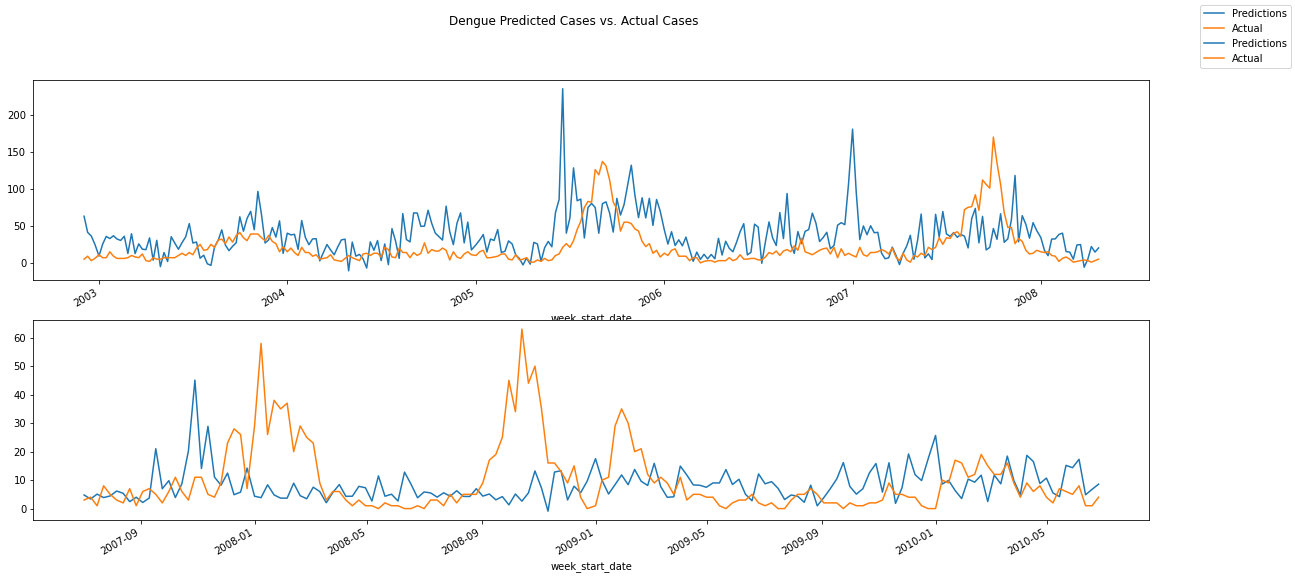

In [15]:
plt.rcParams["figure.figsize"] = (20,9)
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_X_test['fitted'] = sj_rf.predict(sj_X_test)
sj_X_test.fitted.plot(ax=axes[0], label="Predictions")
sj_y_test.plot(ax=axes[0], label="Actual")

iq_X_test['fitted'] = iq_rf.predict(iq_X_test)
iq_X_test.fitted.plot(ax=axes[1], label="Predictions")
iq_y_test.plot(ax=axes[1], label="Actual")

figs.suptitle("Dengue Predicted Cases vs. Actual Cases")
figs.legend()

In [16]:
sj_X_test.drop('fitted',axis=1,inplace=True)
iq_X_test.drop('fitted',axis=1,inplace=True)

In [17]:
#submit data
sj_X_valid, iq_X_valid = get_data('dengue_features_test.csv',
                                    sj_tminus=sj_tminus,
                                    iq_tminus=iq_tminus,
                                    ) 

In [18]:
sj_X_valid

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_8,reanalysis_relative_humidity_percent_8,reanalysis_sat_precip_amt_mm_8,reanalysis_specific_humidity_g_per_kg_8,reanalysis_tdtr_k_8,station_avg_temp_c_8,station_diur_temp_rng_c_8,station_max_temp_c_8,station_min_temp_c_8,station_precip_mm_8
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-04-29,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,294.527143,301.1,296.4,...,54.374431,81.138679,605.642957,16.292343,2.867795,29.433801,6.011904,30.870002,22.980233,362.454253
2008-05-06,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,294.395714,300.8,296.7,...,50.751318,80.834869,539.756003,16.358062,2.865623,29.351330,6.012725,31.028887,23.042595,326.345885
2008-05-13,-0.001500,0.061357,0.151083,0.091529,3.66,299.455714,299.357143,295.308571,302.2,296.4,...,47.128206,80.531058,473.869049,16.423782,2.863451,29.268859,6.013546,31.187773,23.104958,290.237517
2008-05-20,0.072478,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,294.402857,303.0,296.9,...,43.505093,80.227248,407.982095,16.489501,2.861279,29.186388,6.014366,31.346659,23.167320,254.129149
2008-05-27,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,294.760000,302.3,297.3,...,39.881980,79.923437,342.095141,16.555220,2.859108,29.103917,6.015187,31.505544,23.229682,218.020781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-26,-0.087400,-0.016183,0.156343,0.105186,30.34,298.670000,298.885714,294.675714,301.3,296.4,...,7.700000,78.100000,0.000000,15.317143,2.385714,26.128571,6.271429,30.000000,22.200000,6.100000
2013-04-02,-0.203250,-0.077833,0.204171,0.178914,6.55,298.035714,298.157143,294.628571,301.5,295.9,...,15.100000,75.938571,0.000000,14.448571,2.671429,25.300000,6.314286,29.400000,20.600000,26.400000
2013-04-09,-0.117600,-0.008200,0.192700,0.170429,0.00,299.057143,299.328571,294.948571,301.5,297.5,...,7.600000,73.872857,0.000000,14.315714,2.685714,25.328571,6.585714,30.000000,21.100000,34.800000


In [19]:
iq_X_valid

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_8,reanalysis_relative_humidity_percent_8,reanalysis_sat_precip_amt_mm_8,reanalysis_specific_humidity_g_per_kg_8,reanalysis_tdtr_k_8,station_avg_temp_c_8,station_diur_temp_rng_c_8,station_max_temp_c_8,station_min_temp_c_8,station_precip_mm_8
week_start_date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,0.183783,0.142500,0.225129,0.150214,82.29,297.648571,299.214286,296.118571,307.9,293.7,...,231.618537,158.625082,534.177810,15.344242,11.242732,27.667822,8.081084,32.631240,30.798136,28.155594
2010-07-09,0.291657,0.272267,0.330700,0.320914,25.30,298.224286,299.464286,294.831429,307.7,292.2,...,206.920711,150.355117,477.674640,15.426748,11.057181,27.666738,8.344584,32.758867,29.645473,26.031743
2010-07-16,0.208543,0.366457,0.212629,0.255514,62.14,297.955714,298.964286,296.417143,306.4,292.5,...,182.222885,142.085152,421.171471,15.509254,10.871631,27.665653,8.608084,32.886493,28.492811,23.907893
2010-07-23,0.089286,0.063214,0.122057,0.081957,47.80,295.715714,296.642857,293.638571,306.4,289.3,...,157.525059,133.815187,364.668301,15.591760,10.686080,27.664568,8.871585,33.014119,27.340149,21.784043
2010-07-30,0.306100,0.327683,0.250086,0.267914,56.30,298.502857,300.000000,293.892857,308.1,290.5,...,132.827234,125.545222,308.165131,15.674266,10.500530,27.663483,9.135085,33.141746,26.187486,19.660193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-28,0.301471,0.380029,0.280629,0.383186,41.12,297.774286,298.964286,295.638571,305.5,292.7,...,131.300000,94.630000,122.600000,18.148571,8.000000,28.700000,10.833333,34.800000,21.800000,36.800000
2013-06-04,0.247600,0.296343,0.285371,0.350357,71.52,297.167143,298.328571,295.845714,306.3,291.6,...,52.200000,93.091429,88.070000,17.910000,9.400000,27.633333,9.533333,33.600000,22.000000,54.100000
2013-06-11,0.238729,0.251029,0.252586,0.249771,78.96,295.831429,296.607143,294.894286,304.6,290.7,...,121.000000,91.862857,44.300000,18.632857,8.357143,28.333333,10.000000,34.200000,22.400000,53.600000


In [20]:
b = sj_rf.predict(sj_X_valid).astype(int)
sj_predictions = sj_rf.predict(sj_X_valid).astype(int)
iq_predictions = iq_rf.predict(iq_X_valid).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("benchmark.csv")

/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [21]:
sj_predictions, iq_predictions

(array([ 37,  50,  14,  44,  32,   0,  35,  48,  32,  19,  35, 177,  37,
        209,  65,  26,  26,  59,  38,  19,  79,  96,  36,  32,  52, 114,
         64,  48,  67,  52,  20,  85,  43,  47,  20,  18,  48,  18,  28,
         22,  17,  20,  11,  13,  36,  23,  17,  31,   7,  -3,  15,  -1,
          3,   5,   1,  -8,  -3,  16,  20,   9,  27,  28,  14,  63,  49,
          1,  24,  19,  77,  38,  19,  25,  65,  42,  80,  38,  86, 171,
         34,  69,  77, 110, 102,  36,  83,  25,  55,  36,  43,  37,  40,
         38,  47,  39,  48,  28,  38,  45,  36,  59,  24,  12,  17,  17,
         81,  51,  16,   3,  20, -10, -18,  64,  32,  26,  59, 218,  58,
         85, 121,  51,  54, 121, 136,  97,  95,  98,  31,  52, 146, 125,
        162, 105,  66,  77,  73,  21,  36,  52,  30,  26,  33,  35,   6,
         16,   9,  21,  22,  10,  15,  30,  34,   0,   2,  13,  17,   8,
          7,   8,  11,   0,   7,  28,  32,  34,  38,  63,  41,  56,  81,
         68,  66,  33,  31, 159,  54,  64,  83,  61

In [22]:
print('sj', mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))
print('iq', mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

sj 25.861122339221506
iq 9.219897140677158


/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/pico/anaconda3/envs/fai/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


sj 17.274501779359433
iq 7.246260500628908

In [23]:
sj_X_test

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,reanalysis_precip_amt_kg_per_m2_8,reanalysis_relative_humidity_percent_8,reanalysis_sat_precip_amt_mm_8,reanalysis_specific_humidity_g_per_kg_8,reanalysis_tdtr_k_8,station_avg_temp_c_8,station_diur_temp_rng_c_8,station_max_temp_c_8,station_min_temp_c_8,station_precip_mm_8
week_start_date,,,,,,,,,,,,,,,,,,,,,
2002-12-03,-0.24390,-0.120933,0.279086,0.248843,0.00,300.170000,300.314286,295.205714,302.0,298.0,...,25.50,78.808571,17.48,18.191429,2.728571,27.942857,6.685714,31.7,23.9,26.0
2002-12-10,-0.17430,-0.072300,0.199300,0.171300,7.32,299.892857,299.928571,294.978571,301.4,298.3,...,23.50,78.948571,91.69,17.950000,2.600000,27.542857,7.257143,32.2,23.3,6.1
2002-12-17,-0.04300,-0.128950,0.185414,0.208800,0.00,299.378571,299.600000,294.577143,301.2,297.7,...,27.00,79.217143,9.50,18.104286,2.485714,27.985714,7.171429,33.3,23.9,53.3
2002-12-24,0.03580,-0.252800,0.243433,0.136929,6.58,298.638571,298.807143,294.805714,301.1,296.7,...,34.70,77.620000,33.29,17.688571,2.585714,27.542857,6.571429,31.7,23.3,31.3
2003-01-01,-0.07195,-0.045250,0.230457,0.175714,0.00,298.041429,298.085714,294.381429,300.3,295.8,...,9.50,76.167143,14.05,17.265714,3.100000,27.385714,6.542857,31.1,23.3,8.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-03-25,0.07785,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,299.7,294.4,...,2.70,73.565714,0.00,14.408571,3.300000,24.571429,6.442857,28.9,20.0,3.1
2008-04-01,-0.03800,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,299.8,296.5,...,19.70,70.642857,0.00,13.225714,2.071429,24.214286,5.157143,27.2,21.1,35.9
2008-04-08,-0.15520,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,299.4,295.8,...,10.17,74.228571,0.00,14.367143,2.157143,24.800000,6.242857,28.3,21.1,6.4


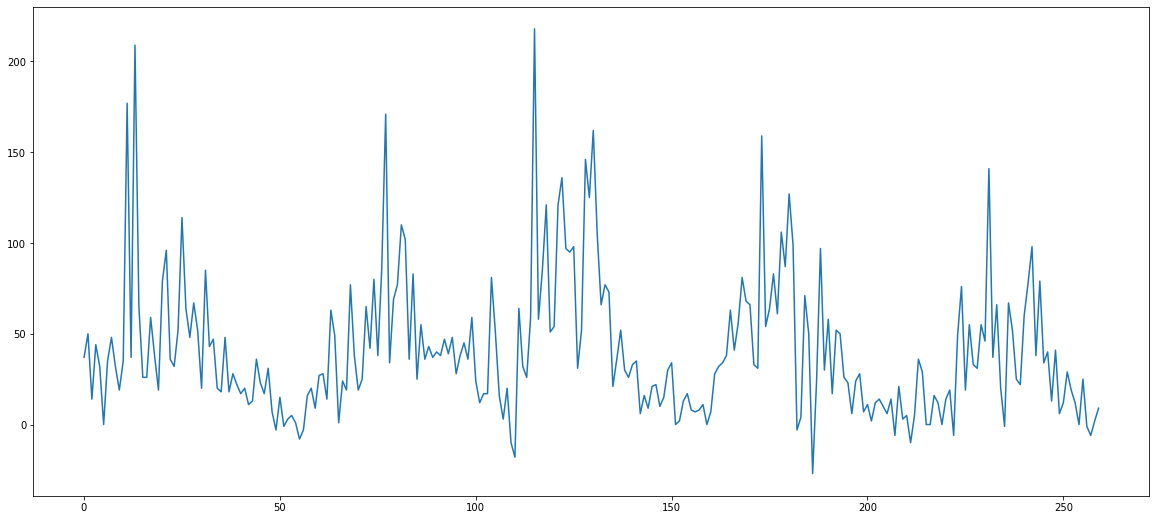

In [24]:
plt.plot(sj_predictions)

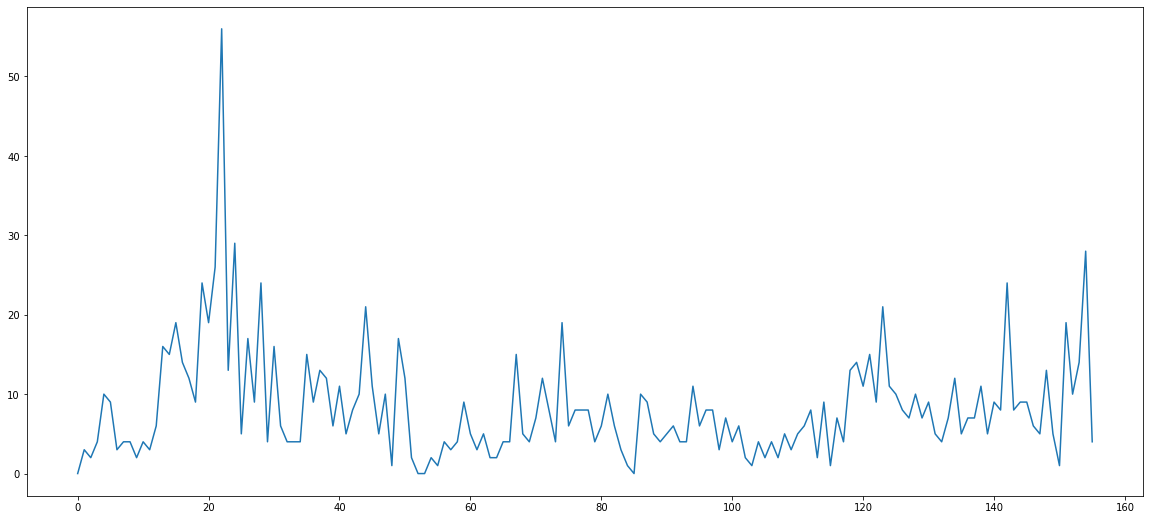

In [25]:
plt.plot(iq_predictions)